In [1]:
!pip install qiskit qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00


In [3]:
!pip install qiskit-aer --quiet



=== Grover 3-qubit (marked=001, iterations=1) ===


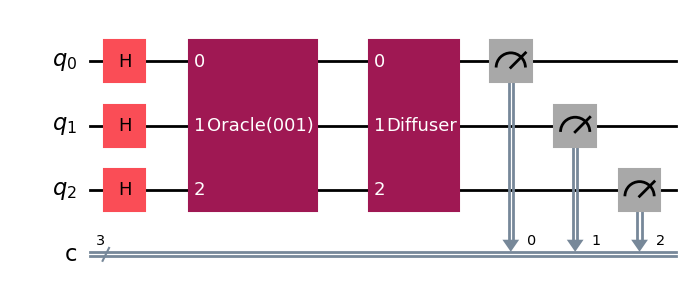


Results for marked=001


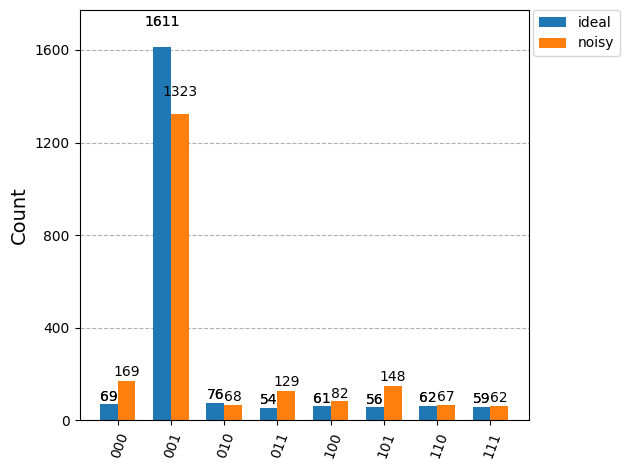


=== Grover 3-qubit (marked=111, iterations=1) ===


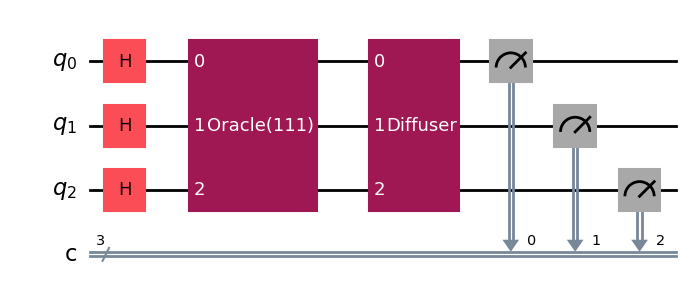


Results for marked=111


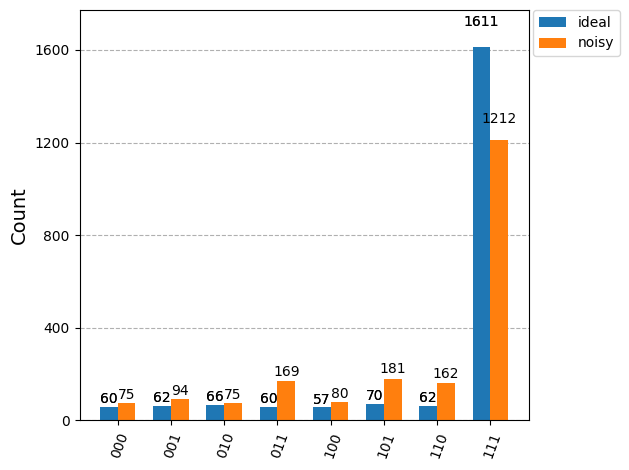


=== Grover 3-qubit (marked=010, iterations=1) ===


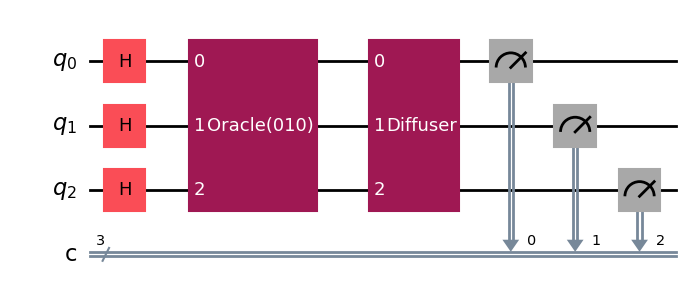


Results for marked=010


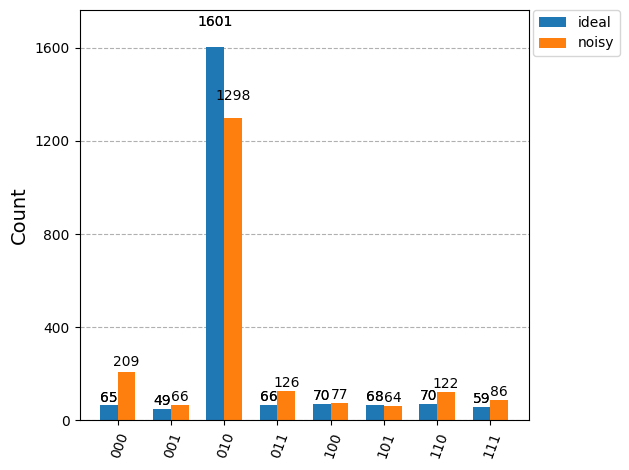


=== Grover 4-qubit (marked=0110, iterations=1) ===


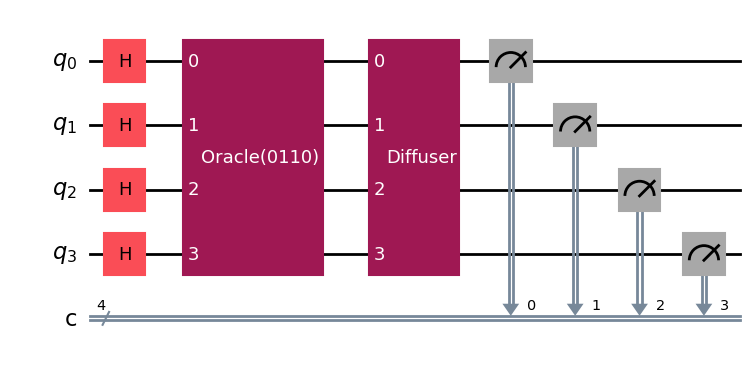


Results for 4-qubit marked=0110


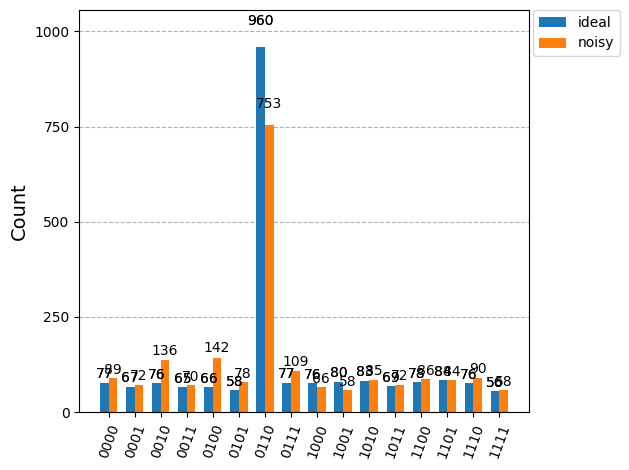


=== Grover 3-qubit (marked=010, iterations=1) ===


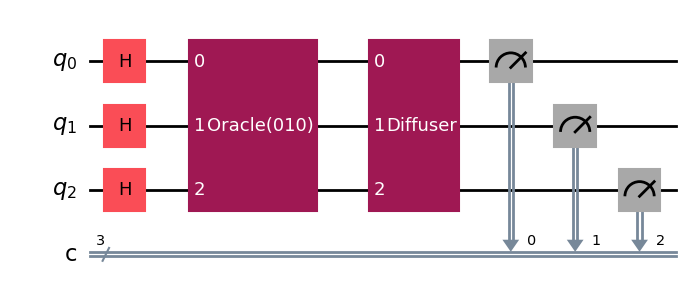


Results for marked=010 iterations=1


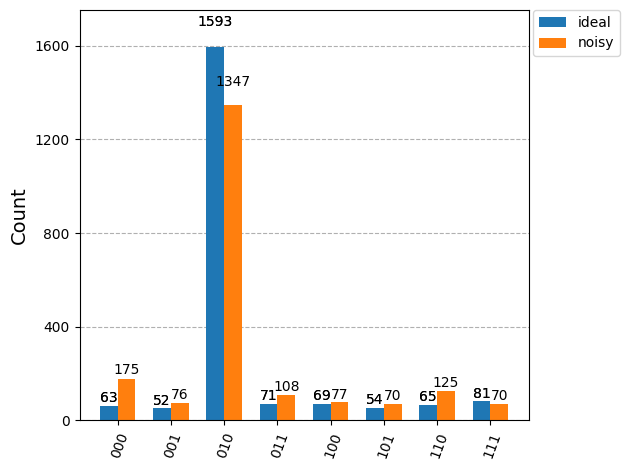


=== Grover 3-qubit (marked=010, iterations=2) ===


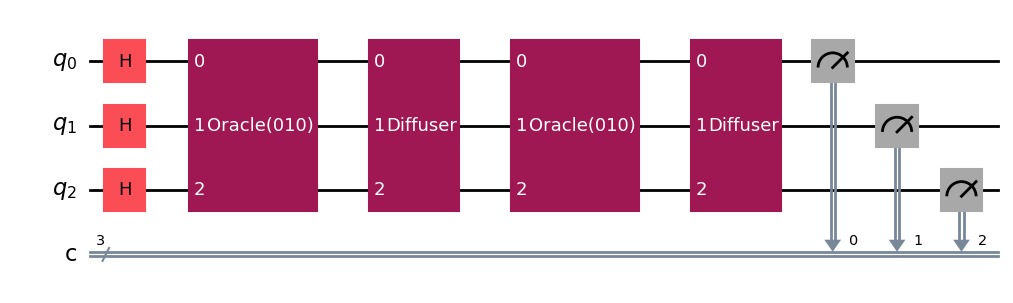


Results for marked=010 iterations=2


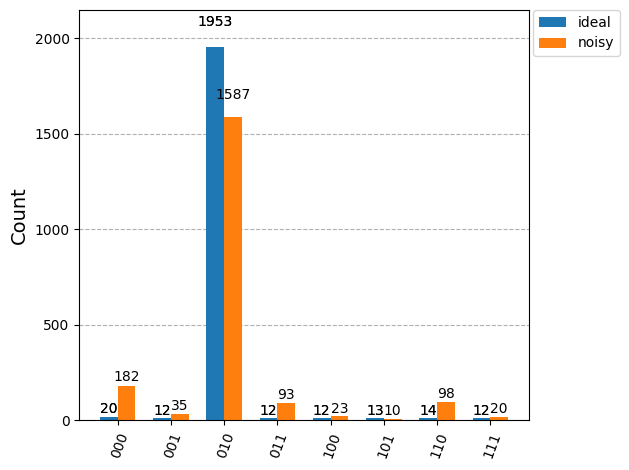


All experiments complete.


In [7]:
# Fixed Grover full code: transpile before running (no more AerError)
!pip install qiskit qiskit-aer pylatexenc --quiet

import math
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.visualization import plot_histogram

# --- Helpers to create Oracle and Diffuser as gates ---
def grover_oracle(n, marked_state):
    qc = QuantumCircuit(n)
    # marked_state provided as MSB..LSB string
    # flip where bit == '0'
    for i, bit in enumerate(reversed(marked_state)):
        if bit == '0':
            qc.x(i)
    # phase flip via MCX on last qubit
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)  # multi-controlled X
    qc.h(n-1)
    for i, bit in enumerate(reversed(marked_state)):
        if bit == '0':
            qc.x(i)
    return qc.to_gate(label=f"Oracle({marked_state})")

def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc.to_gate(label="Diffuser")

# --- Build full Grover circuit (returns QuantumCircuit) ---
def grover_algorithm(n=3, marked_state="111", iterations=1):
    qc = QuantumCircuit(n, n)
    qc.h(range(n))
    oracle_gate = grover_oracle(n, marked_state)
    diffuser_gate = grover_diffuser(n)
    for _ in range(iterations):
        qc.append(oracle_gate, range(n))
        qc.append(diffuser_gate, range(n))
    qc.measure(range(n), range(n))
    return qc

# --- Safe draw helper ---
def safe_draw(qc, title=None):
    if title:
        print(f"\n=== {title} ===")
    try:
        display(qc.draw('mpl'))
    except Exception:
        print(qc.draw('text'))

# --- Noise model helper ---
def make_simple_noise_model():
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(0.03, 1), ['h', 'x'])
    nm.add_all_qubit_quantum_error(depolarizing_error(0.08, 2), ['cx'])
    nm.add_all_qubit_readout_error(ReadoutError([[0.95, 0.05],[0.08, 0.92]]))
    return nm

# --- Run function: transpile then run on AerSimulator ---
def run_and_get_counts(qc, noisy=False, shots=2048):
    sim = AerSimulator()
    # transpile to the simulator's basis first (avoids unknown-instruction errors)
    tcirc = transpile(qc, sim)
    if noisy:
        nm = make_simple_noise_model()
        # When using noise_model we must pass it to simulator.run; also transpile again with noise?
        # Using the same transpiled circuit is fine for this simple example.
        job = sim.run(tcirc, noise_model=nm, shots=shots)
    else:
        job = sim.run(tcirc, shots=shots)
    res = job.result()
    return res.get_counts()

# --- Example experiments ---

# 1) Different marked states (3 qubits) and show circuits + histograms
marked_examples = ['001','111','010']
for m in marked_examples:
    qc = grover_algorithm(n=3, marked_state=m, iterations=1)
    safe_draw(qc, title=f"Grover 3-qubit (marked={m}, iterations=1)")
    counts_ideal = run_and_get_counts(qc, noisy=False, shots=2048)
    counts_noisy = run_and_get_counts(qc, noisy=True, shots=2048)
    print(f"\nResults for marked={m}")
    display(plot_histogram([counts_ideal, counts_noisy], legend=['ideal','noisy']))
    plt.show()

# 2) 4-qubit example (marked '0110'), 1 iteration
m4 = '0110'
qc4 = grover_algorithm(n=4, marked_state=m4, iterations=1)
safe_draw(qc4, title=f"Grover 4-qubit (marked={m4}, iterations=1)")
counts4_ideal = run_and_get_counts(qc4, noisy=False, shots=2048)
counts4_noisy = run_and_get_counts(qc4, noisy=True, shots=2048)
print(f"\nResults for 4-qubit marked={m4}")
display(plot_histogram([counts4_ideal, counts4_noisy], legend=['ideal','noisy']))
plt.show()

# 3) Multiple iterations for amplification (3-qubit, marked='010')
m='010'
for it in [1,2]:
    qc_it = grover_algorithm(n=3, marked_state=m, iterations=it)
    safe_draw(qc_it, title=f"Grover 3-qubit (marked={m}, iterations={it})")
    ci = run_and_get_counts(qc_it, noisy=False, shots=2048)
    cn = run_and_get_counts(qc_it, noisy=True, shots=2048)
    print(f"\nResults for marked={m} iterations={it}")
    display(plot_histogram([ci, cn], legend=['ideal','noisy']))
    plt.show()

# Done
print("\nAll experiments complete.")
